# Python Pipeline for Differential Methylation Analysis

This script is an attempt to identifying differentially active genomic windows. The pipeline's logic can be dissected into four principal stages:   

1. **Data Filtration and Biological Annotation**: Initial pre-processing steps remove low-signal windows to enhance statistical power and annotate each window with a primary biological category to facilitate downstream interpretation.

2. **Baseline Bias Estimation**: A novel step that calculates and corrects for systematic, technology-inherent biases associated with different sub-features (termed 'clusters') within the windows.

3. **Core Statistical Testing**: For each window, a sophisticated statistical test is performed to assess whether the observed variation among its constituent clusters is greater than expected by chance, after accounting for overdispersion.

4. **Effect Size Quantification**: The magnitude of the differential effect is quantified using a robust Empirical Bayes shrinkage approach, and the resulting p-values are adjusted to control the false discovery rate across the tens of thousands of tests performed.

---

## 1. Setup: Import Libraries

First, we import the necessary Python libraries for data manipulation, numerical operations, statistical calculations, and plotting.

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import logit, expit
from scipy.stats import chi2

## 2. Data Loading and Preprocessing

This section covers loading the annotated methylation data and performing initial cleaning.

### Load Annotated Methylation Data

The data is loaded from a tab-separated file into a pandas DataFrame. Each row represents a specific genomic location within a cell cluster. For the pipeline used to generate the data table from raw sequenced data, refer to [placeholder].

- **`cluster`**: The cell cluster ID.
- **`chr`**: Chromosome number
- **`start`, `end`**: Base pair range in 100BP window.
- **`score`**: Methylation ratio (`c / (c+t)`).
- **`c`**: Number of methylated reads (Cytosines).
- **`t`**: Number of unmethylated reads.
- **`n`**: Unused parameter. refer to sequencing tool. 
- **`flag_{region}`**: Unused parameter. A binary flag indicating overlaps with regions of interest (here we have euchromatic/heterochromatic genes/transposons)


- **`score_masked`**: List of scores where some can be NaN due to prior filtering. Those NaN rows Will be voided in our pipeline.

In [31]:
df = pd.read_csv('../data/annotated_filtered_col.CG_2.fast.tsv', sep='\t')
df.head()

,cluster,chr,start,end,score,c,t,n,flag_euc_gene,flag_het_gene,flag_euc_TE,flag_het_TE,score_masked
0,0,1,101,200,0.8951,350,41,6,False,False,False,False,0.8951
1,0,1,301,400,0.5487,62,51,2,False,False,False,False,0.5487
2,0,1,401,500,0.8246,47,10,1,False,False,False,False,0.8246
3,0,1,501,600,0.7206,98,38,3,False,False,False,False,0.7206
4,0,1,601,700,0.8982,203,23,6,False,False,False,False,0.8982


### Quality Control (QC)

We filter the data by removing any rows that have a `NaN` value in the `score_masked` column. This step ensures that we only work with data points that have survived previous filtering stages.

In our data, we already performed QC on coverage via thresholds defined for methylation contexts: `CG`, `CHG`, `CHH`. The respective cutoff is `0.2`, `0.1`, `0.05`: meaning that if a window has consistently below these methylation score, it will be voided from the table (here we marked the score as `NaN` since we only care about methylated regions). Before performing this, we also filtered any window that have strictly less than 5 reads for QC. 

In [32]:
print(f"Original shape: {df.shape}")
df = df.dropna(subset=['score_masked'])
print(f"Shape after dropping NaNs: {df.shape}")

Original shape: (5925989, 13)
Shape after dropping NaNs: (5441492, 13)


### (Optional)Assign primary category for context

In [54]:
def assign_primary_category(df):
    df = df.copy()
    df['category'] = np.select(
        [
            df['flag_euc_gene'],
            df['flag_het_gene'],
            df['flag_euc_TE'],
            df['flag_het_TE']
        ],
        [
            'euc_gene',
            'het_gene',
            'euc_te',
            'het_te'
        ],
        default='no_context'
    )
    return df

In [37]:
df = assign_primary_category(df)
df.head(10)

,cluster,chr,start,end,score,c,t,n,flag_euc_gene,flag_het_gene,flag_euc_TE,flag_het_TE,score_masked,category
0,0,1,101,200,0.8951,350,41,6,False,False,False,False,0.8951,no_context
1,0,1,301,400,0.5487,62,51,2,False,False,False,False,0.5487,no_context
2,0,1,401,500,0.8246,47,10,1,False,False,False,False,0.8246,no_context
3,0,1,501,600,0.7206,98,38,3,False,False,False,False,0.7206,no_context
4,0,1,601,700,0.8982,203,23,6,False,False,False,False,0.8982,no_context
5,0,1,701,800,0.9623,51,2,2,False,False,False,False,0.9623,no_context
6,0,1,801,900,0.8901,81,10,4,False,False,False,False,0.8901,no_context
7,0,1,901,1000,0.8524,179,31,6,False,False,False,False,0.8524,no_context
8,0,1,2001,2100,0.0000,0,136,2,False,False,False,False,0.0000,no_context
9,0,1,5401,5500,0.5000,200,200,8,True,False,False,False,0.5000,euc_gene


## 3. Statistical Modeling and Functions

Below we define the core functions for our statistical analysis. The main goal is to calculate a chi-square statistic for each genomic window to test for differential methylation.

### Calculate Global Cluster Offsets (`fit_offsets`)

This function calculates a global, baseline methylation level for each cell **cluster**. By aggregating counts across the entire genome, we can determine each cluster's typical methylation propensity. These "offsets" are calculated in logit space and are used to establish the null hypothesis for our statistical test.

In [38]:
def fit_offsets(df_all):
    """Calculates global methylation offsets for each cluster."""
    # Aggregate methylated (c) and unmethylated (t) counts for each cluster
    agg = df_all.groupby('cluster')[['c','t']].sum()
    # Array of total reads per cluster
    M = agg.sum(axis=1)
    # Raw proportion per cluster
    p = agg['c'] / M

    # Convert to logit space to ensure linearity and comparability
    d = logit(np.clip(p, 1e-6, 1-1e-6))

    # Return offset in logit space
    return d - np.average(d, weights=M)

### Calculate Window-wise Statistics (`window_stats`)

This function iterates through each unique genomic window (defined by `chr`, `start`, `end`) and performs the chi-square test.

The key steps for each window are:
1. **Formulating the Null Hypothesis in Logit Space.**
2. **The Chi-Squared Statistic for Goodness-of-Fit.**
3. **Modeling Overdispersion (phi).**
4. **Quantifying Effect Size with Empirical Bayes Shrinkage (delta_max).**

In [39]:
def window_stats(df_all, deltas, tau=20.0, eps=1e-6):
    """Computes chi-square statistics for each genomic window."""
    out = []

    # Empirical-Bayes prior from ALL windows
    agg = df_all.groupby('cluster')[['c','t']].sum()
    mu = agg['c'].sum() / agg.sum(axis=1).sum()
    a0, b0 = mu * tau, (1 - mu) * tau # pseudo-successes and failures
    
    for (chr_, start, end), g in df_all.groupby(['chr','start','end']):
        c = g['c'].to_numpy(); t = g['t'].to_numpy(); m = c + t
        k = g['cluster'].to_numpy()

        # Keep clusters with sufficient coverage (>= 5 reads)
        keep = m >= 5
        if keep.sum() < 2:
            continue
        c, m, k = c[keep], m[keep], k[keep]

        # Calculate the expected methylation rate (p0) under the null hypothesis
        pbar = c.sum() / m.sum()
        p0 = expit(logit(np.clip(pbar, 1e-6, 1-1e-6)) + deltas.loc[k].to_numpy())

        # Pearson X^2 with binomial variance, epsilon-stabilized
        E = m * p0
        Var = m * p0 * (1 - p0) + eps
        X2 = ((c - E)**2 / Var).sum()
        dfree = len(c) - 1

        # # Calculate max deviation and identify high/low clusters
        # p_hat = c / m
        # dev = np.abs(p_hat - p0)
        # dmax = float(dev.max() - dev.min())
        # hi = int(k[p0.argmax()])
        # lo = int(k[p0.argmin()])

        # EB-shrinking approach
        p_tilde = (c + a0) / (m + a0 + b0)
        dmax = float(p_tilde.max() - p_tilde.min())
        hi = int(k[p_tilde.argmax()])
        lo = int(k[p_tilde.argmin()])
        

        out.append((chr_, start, end, X2, m.sum(), dfree, dmax, hi, lo))

    res = pd.DataFrame(out, columns=['chr','start','end','X2', '∑m', 'df','delta_max','hi_cluster','lo_cluster'])

    # Correct for overdispersion using a global phi factor
    phi = np.median(res['X2'] / np.maximum(res['df'], 1)) if len(res) else 1.0
    res['pval'] = 1 - chi2.cdf(res['X2'] / max(phi, 1e-6), res['df'])
    res['phi'] = phi
    return res

### More on $\chi^2$ statistic

To quantify the deviation from this null hypothesis, the function employs a test statistic based on the **Pearson's chi-squared formula**: $\chi^2 = \sum \frac{(Observed - Expected)^2}{Variance}$.

In the script, this is calculated as `X2 = ((c - E)**2 / Var).sum()`. The denominator, $Var$, is the expected variance of the counts. The term $m \cdot p_0 \cdot (1-p_0)$ represents the theoretical variance of a *binomially distributed random variable* with $m$ trials and success probability $p_0$. A small constant, $eps$, is added for numerical stability, preventing division by zero in cases of very low variance. The degrees of freedom for this test, $dfree$, are set to $len(c) - 1$, which is the number of clusters in the window minus $1$. 

Essentially we want to answer the question: **"After accounting for the known, systematic biases of each cluster type, is there still more variation among the clusters in this window than can be explained by random sampling noise around a single, window-wide baseline?"**

### About $\phi$ during p-value calculation

A critical feature of genomic count data is that its **observed variance often exceeds the theoretical variance** predicted by simple distributions like the binomial or Poisson. This phenomenon, known as **overdispersion**, can arise from unmodeled biological or technical factors. Ignoring it might lead to an inflated test statistic and a high **false-positive rate**. Thus we decided to adopt a robust approach known as a **quasi-likelihood method**.

It calculates a single, dataset-wide overdispersion parameter, **$\phi$ (phi)**, as the median of the ratio $X^2 / dfree$ across all tested windows. This $\phi$ value represents the empirical inflation factor of the observed variance relative to the theoretical binomial variance. A $\phi > 1$ indicates the presence of overdispersion. The final p-value is then calculated from a chi-squared distribution, but with the test statistic scaled by this factor: $1 - F_{\chi^2}(\frac{X^2}{\phi}, df)$, where $F_{\chi^2}$ is the cumulative distribution function of the chi-squared distribution. This adjustment effectively "cools down" the test statistics across the entire dataset to account for the observed level of overdispersion, yielding more accurate and reliable p-values. 

### On Empirical Bayes Shrinkage (EB)

Statistical significance (a low p-value) does not always imply practical or biological significance. A window with very high read coverage might yield a tiny p-value for a trivially small difference in proportions. Conversely, a window with low coverage might show a large raw difference that is entirely due to sampling noise. To address this, the pipeline incorporates a state-of-the-art Empirical Bayes (EB) shrinkage method to provide a robust estimate of the effect size.

The EB framework "borrows strength" from the entire dataset to stabilize the estimates for individual data points, particularly those with low information (low counts).1 The script implements this using a Beta-Binomial model. It assumes that the true, underlying proportions for all clusters are drawn from a common Beta distribution, which serves as the "prior." The parameters of this prior, `a0` and `b0`, are estimated from the global distribution of all counts in the dataset. The global mean proportion, $\mu$, determines the mean of the prior, while a hyperparameter, $\tau$ (tau, set to 20.0), controls the "tightness" or strength of the prior. A higher $\tau$ implies a stronger belief that all proportions are similar to the global mean, leading to more aggressive shrinkage.

The shrunken proportion for each cluster, $\tilde{p}$ (p_tilde), is then calculated as the posterior mean of the proportion under this model: $\tilde{p} = (c + a_0) / (m + a_0 + b_0)$. This calculation has an intuitive interpretation: it is like adding $a_0$ "pseudo-successes" and $b_0$ "pseudo-failures" to the observed counts. For clusters with high coverage (large $m$), the observed data dominates, and the shrunken estimate is close to the raw proportion. For clusters with low coverage (small $m$), the prior dominates, and the noisy raw proportion is "shrunk" towards the global mean $\mu$.

The final effect size metric, delta_max, is the difference between the maximum and minimum shrunken proportions within the window: $d_{max} = \max(\tilde{p}) - \min(\tilde{p})$. This provides a reliable measure of the magnitude of differential activity, de-noised and stabilized by the EB procedure. The dual reporting of a p-value (statistical significance) and a shrunken effect size (practical significance) is a best practice in modern bioinformatics.19 It allows researchers to prioritize discoveries that are not only statistically improbable under the null hypothesis but also exhibit an effect of a magnitude likely to be biologically relevant.

### Multiple Hypothesis Correction (`bh_fdr`)

The final analytical step of the pipeline addresses one of the most fundamental challenges in genomics: *the multiple hypothesis testing problem*. When performing tens or hundreds of thousands of statistical tests simultaneously, as is the case when analyzing genomic windows, a conventional p-value threshold (e.g., 0.05) is guaranteed to generate a large number of false positives by chance alone. The `bh_fdr` function implements the **Benjamini-Hochberg procedure**, a widely adopted standard for controlling the False Discovery Rate in high-dimensional settings.

### Context
- **Multiple Testing Problem**: If one performs 100,000 independent statistical tests on data where the null hypothesis is always true, a p-value threshold of 0.05 would be expected to produce approximately 5,000 "significant" results purely by chance. Traditional methods to combat this, such as the Bonferroni correction, control the Family-Wise Error Rate (FWER)—the probability of making even a single false positive. However, FWER control is exceedingly stringent for genomic-scale analyses and often results in a drastic loss of statistical power, causing researchers to miss many true biological effects.

- **False Discovery Rate (FDR) Control**: The concept of the False Discovery Rate (FDR) offers a more practical and powerful alternative. The FDR is defined as the expected proportion of false positives among all features declared significant (i.e., the rejected null hypotheses). Controlling the FDR at a level of 5% does not guarantee zero false positives; instead, it provides an assurance that, on average, no more than 5% of the discoveries in the final list will be false leads.

This framework is exceptionally well-suited for discovery-oriented research in genomics. The primary goal is often to generate a reliable list of candidate genes or regions for further experimental validation. In this context, tolerating a small, controlled fraction of false discoveries is an acceptable trade-off for the substantial gain in power to detect true biological signals.8 The BH procedure has become the de facto standard for FDR control in bioinformatics due to its statistical power and its robustness under various conditions of dependency between tests.

### **The Benjamini-Hochberg (BH) Procedure** 

The `bh_fdr` function implements the BH procedure to calculate adjusted p-values, often called **"q-values"**. The q-value for a specific test represents the minimum FDR at which that test would be deemed significant.

The algorithm is as follows:

1. All $m$ p-values from the window_stats function are collected and sorted in ascending order: $p_{(1)} \le p_{(2)} \le \dots \le p_{(m)}$.
2. Each sorted p-value is assigned a rank, $i$, from 1 to $m$.
3. The BH-adjusted p-value (q-value) for the $i$-th sorted p-value is calculated. A common procedure is to find the largest rank $k$ such that $p_{(k)} \le \frac{k}{m} \alpha$, where $\alpha$ is the desired FDR level, and then declare all tests with p-values up to $p_{(k)}$ as significant.
4. The provided function calculates the q-value for each test directly. The implementation is computationally efficient and mathematically sound. It first calculates the raw scaled p-value, $p \times m / rank$. It then sorts these values and uses a cumulative minimum operation (np.minimum.accumulate) to enforce the "step-up" property of the BH procedure, which ensures that if a given p-value is significant, all smaller p-values are also significant. 

In [40]:
def bh_fdr(p):
    """Benjamini-Hochberg False Discovery Rate correction."""
    if len(p) == 0:
        return p
    r = np.argsort(p)
    ranks = np.empty_like(r); ranks[r] = np.arange(1, len(p) + 1)
    q = p * len(p) / np.maximum(ranks, 1)
    q_sorted = np.minimum.accumulate(np.sort(q)[::-1])[::-1]
    out = np.empty_like(q_sorted); out[r] = q_sorted
    return np.clip(out, 0, 1)

## 4. Running the Analysis Pipeline

Now, we execute the functions in order to produce the final statistics table.

In [46]:
# 1. Calculate global cluster offsets from the entire dataset
print("Fitting global cluster offsets...")
deltas = fit_offsets(df)

# 2. Compute window-by-window statistics
print("Calculating window stats (this may take a while)...")
stats = window_stats(df, deltas, tau=20.0)

# 3. Apply FDR correction to get q-values
print("Applying FDR correction...")
stats['qval'] = bh_fdr(stats['pval'].to_numpy())

print("Analysis complete!")
stats.head()

Fitting global cluster offsets...
Calculating window stats (this may take a while)...
Applying FDR correction...
Analysis complete!


,chr,start,end,X2,∑m,df,delta_max,hi_cluster,lo_cluster,pval,phi,qval
0,1,101,200,19.643935,1639,16,0.111302,15,16,8.009210e-01,1.763769,1.000000
1,1,301,400,25.119604,461,12,0.367107,14,9,2.855219e-01,1.763769,0.733897
2,1,401,500,51.510664,206,10,0.457569,5,12,1.154327e-03,1.763769,0.016258
3,1,501,600,95.127091,468,13,0.514141,5,9,6.210913e-07,1.763769,0.000028
4,1,601,700,53.657379,1108,13,0.185322,14,9,4.092567e-03,1.763769,0.043490


###  (Optional) Calculating test statistics with respect to their context

In [44]:
results = []
for cat in ['euc_gene','het_gene','euc_te','het_te','no_context']:
    print("calculating individual stat for " + cat + "...")
    sub = df[df['category']==cat]
    if sub.empty: continue
    stats = window_stats(sub, deltas, tau=20.0)
    stats['category'] = cat
    stats['qval'] = bh_fdr(stats['pval'].to_numpy())
    results.append(stats)

dmw = pd.concat(results, ignore_index=True) if results else pd.DataFrame()

calculating individual stat for euc_gene...
calculating individual stat for het_gene...
calculating individual stat for euc_te...
calculating individual stat for het_te...
calculating individual stat for no_context...


In [50]:
dmw.head()

,chr,start,end,X2,∑m,df,delta_max,hi_cluster,lo_cluster,pval,phi,category,qval
0,1,5401,5500,9.582772,1861,15,0.136092,15,9,0.977440,1.562687,euc_gene,1.000000
1,1,7001,7100,61.195724,1423,16,0.289340,15,16,0.001031,1.562687,euc_gene,0.011590
2,1,11201,11300,75.622330,473,14,0.236540,5,16,0.000011,1.562687,euc_gene,0.000229
3,1,23901,24000,21.550300,629,14,0.217177,14,9,0.465430,1.562687,euc_gene,0.914765
4,1,24001,24100,22.330612,643,15,0.351289,15,9,0.503667,1.562687,euc_gene,0.945032


### **Explanation of Output Columns**

The `stats` DataFrame contains the results of the differential methylation analysis for each genomic window. Here is a breakdown of what each column represents:

-   **`chr`, `start`, `end`**: These three columns define the **genomic coordinates** for each window that was tested. For example, `chr1`, `101`, `200` refers to the 100 base-pair region from position 101 to 200 on chromosome 1.

-   **`X2` ($X^2$)**: This is the **Pearson's chi-square statistic** for the window. It quantifies the difference between the observed number of methylated reads in each cell cluster and the number of methylated reads we would *expect* to see if there were no real difference in methylation patterns between the clusters (the null hypothesis). A **higher $X^2$ value** indicates a larger deviation from the null hypothesis and suggests a stronger signal of differential methylation.

-   **`∑m`**: This represents the **total sum of reads** (methylated `c` + unmethylated `t`) across all cell clusters that had sufficient coverage (>= 5 reads) within that window. It's a measure of the statistical power for the test in that window.

-   **`df`**: This stands for **degrees of freedom**. For the chi-square test in this context, it is calculated as `n - 1`, where `n` is the number of cell clusters that were included in the test for that window.

-   **`delta_max`**: This is a measure of the **maximum deviation between any clusters** for a specific window. It represents the largest difference between the observed methylation proportion and the expected methylation proportion among all the clusters in that window. It gives an intuitive sense of how different the most extreme clusters are from the baseline.

-   **`hi_cluster` & `lo_cluster`**: These columns identify the cluster IDs that showed the **highest** and **lowest** deviation towards methylation, respectively, based on the expected methylation rate ($p_0$). They tell you which specific cell populations are driving the differential methylation signal.

-   **`pval`**: This is the **p-value** calculated from the chi-square statistic and the degrees of freedom. It represents the probability of observing a $X^2$ value as extreme as, or more extreme than, the one calculated, assuming the null hypothesis is true. A low p-value (e.g., < 0.05) suggests that the observed variation is statistically significant.

-   **`phi` ($\phi$)**: This is a **dispersion parameter**. Biological count data often exhibits more variance than predicted by simple statistical models (a phenomenon called "overdispersion"). The `phi` value is calculated from the median of all $X^2$ statistics and is used to adjust the chi-square test, making the p-value calculation more robust and reducing false positives.

-   **`qval`**: This is the **FDR-adjusted p-value** (or q-value), calculated using the Benjamini-Hochberg procedure. When you perform thousands of statistical tests simultaneously, you increase the chance of getting false positives. The q-value corrects for this multiple testing problem. It represents the expected proportion of false positives among all windows called significant at a given q-value threshold. It is best practice to use the **q-value**, not the p-value, for final significance filtering.

## 5. Results and Visualization


In [53]:
#example gene AT2G10940
stats[(stats["start"]>=4311101) & (stats["start"]<=4312001) & (stats['chr']==2)]

,chr,start,end,X2,∑m,df,delta_max,hi_cluster,lo_cluster,pval,phi,qval
101736,2,4311101,4311200,155.219175,451,14,0.524933,5,16,9.028334e-13,1.763769,1.246453e-10
101737,2,4311201,4311300,382.221228,999,16,0.412601,15,16,0.000000e+00,1.763769,0.000000e+00
101738,2,4311301,4311400,799.584471,1659,16,0.416790,15,16,0.000000e+00,1.763769,0.000000e+00
101739,2,4311401,4311500,861.211556,2093,16,0.366708,15,16,0.000000e+00,1.763769,0.000000e+00
101740,2,4311501,4311600,481.392704,1266,16,0.518455,15,16,0.000000e+00,1.763769,0.000000e+00
101741,2,4311601,4311700,862.742622,2584,16,0.270182,15,16,0.000000e+00,1.763769,0.000000e+00
101742,2,4311701,4311800,494.518497,1509,16,0.407970,15,16,0.000000e+00,1.763769,0.000000e+00
101743,2,4311801,4311900,1152.092310,2742,16,0.338997,15,16,0.000000e+00,1.763769,0.000000e+00
101744,2,4311901,4312000,794.870231,1592,16,0.356190,15,16,0.000000e+00,1.763769,0.000000e+00


In [49]:
#segment from example gene AT2G10940
dmw[(dmw["start"]>=4311101) & (dmw["start"]<=4312001) & (dmw['chr']==2)]

,chr,start,end,X2,∑m,df,delta_max,hi_cluster,lo_cluster,pval,phi,category,qval
140949,2,4311101,4311200,155.219175,451,14,0.524933,5,16,1.605938e-12,1.790837,het_gene,9.757455e-11
140950,2,4311201,4311300,382.221228,999,16,0.412601,15,16,0.000000e+00,1.790837,het_gene,0.000000e+00
140951,2,4311301,4311400,799.584471,1659,16,0.416790,15,16,0.000000e+00,1.790837,het_gene,0.000000e+00
140952,2,4311401,4311500,861.211556,2093,16,0.366708,15,16,0.000000e+00,1.790837,het_gene,0.000000e+00
140953,2,4311501,4311600,481.392704,1266,16,0.518455,15,16,0.000000e+00,1.790837,het_gene,0.000000e+00
140954,2,4311601,4311700,862.742622,2584,16,0.270182,15,16,0.000000e+00,1.790837,het_gene,0.000000e+00
140955,2,4311701,4311800,494.518497,1509,16,0.407970,15,16,0.000000e+00,1.790837,het_gene,0.000000e+00
140956,2,4311801,4311900,1152.092310,2742,16,0.338997,15,16,0.000000e+00,1.790837,het_gene,0.000000e+00
140957,2,4311901,4312000,794.870231,1592,16,0.356190,15,16,0.000000e+00,1.790837,het_gene,0.000000e+00


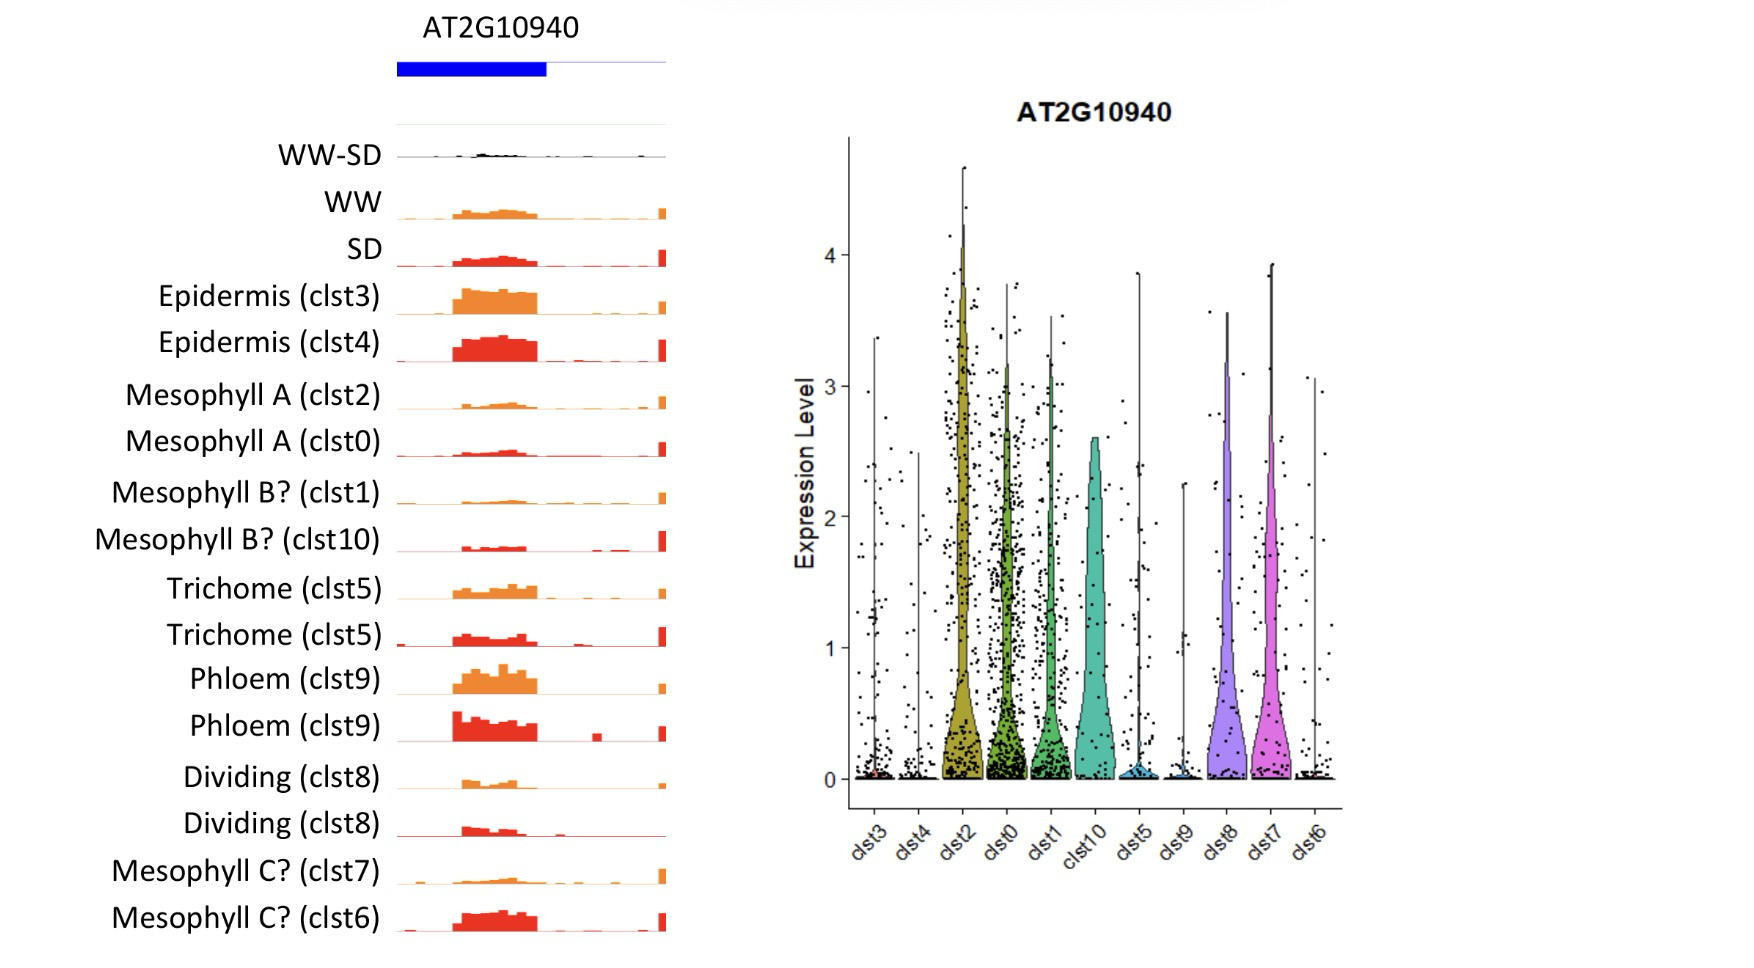

**Note: above reference graph belongs to Dr. James Walker. Demonstration purpose only.**

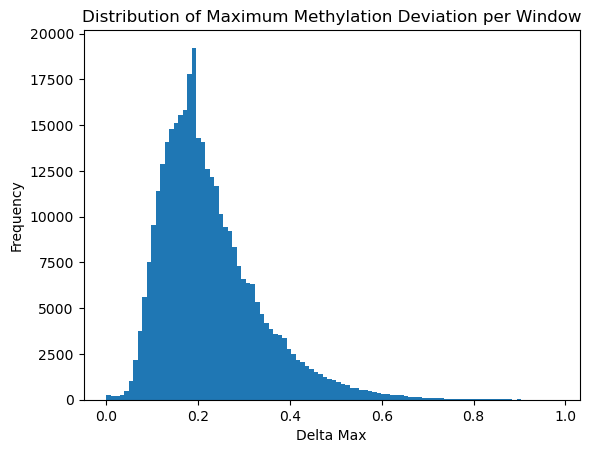

In [9]:
plt.hist(stats['delta_max'], bins=100)
plt.xlabel("Delta Max")
plt.ylabel("Frequency")
plt.title("Distribution of Maximum Methylation Deviation per Window")
plt.show()

--- 
## 6. Saving Results

Finally, the resulting statistics table is saved to a CSV file for further analysis, filtering, and visualization.

In [ ]:
output_path = "../data/x2_CG_stat_all_std.csv"
stats.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")